In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import simpy
import scipy.stats as st
import os
import math
import heapq
from scipy import stats
from scipy.stats import t, sem

In [2]:
SAVE_DIR = 'media'
os.makedirs(SAVE_DIR, exist_ok=True)
RANDOM_SEED = 42
NEW_CUSTOMERS = 200
INTERVAL_CUSTOMERS = 10.0
QUEUE_TIME = 5.0
SIMULATIONS = 100
SERVICE_TIME = 12.0

### 1.
Using the Erlang C Formula (A. Willig, 1999), which calculates the probability of queuing we find the following:

#### M/M/2 Queue:

1. **Erlang C Formula**: 
   $$ P_w = \frac{\frac{(\rho \cdot 2)^2}{2!} \cdot \frac{1}{1 - \rho}}{\sum_{k=0}^{1} \frac{(\rho \cdot 2)^k}{k!} + \frac{(\rho \cdot 2)^2}{2!} \cdot \frac{1}{1 - \rho}} $$

2. **Average Waiting Time in Queue**:
   $$ W_q = \frac{P_w}{2\mu - \lambda} $$

3. **Total Average Time in System**:
   $$ W = W_q + \frac{1}{\mu} $$

#### M/M/1 Queue:

1. **Average Waiting Time in Queue**:
   $$ \rho' = \frac{\lambda'}{\mu} = \frac{\rho}{2} $$
   $$ W_q' = \frac{1}{\mu - \lambda'} $$

2. **Total Average Time in System**:
   $$ W' = W_q' + \frac{1}{\mu} $$

It makes sense that the queue time in a M/M/N system where $N>2$ has shorter queue times. Non-mathematically this can be thought as two supermarkets where one supermarket only has one cashier (N=1) available in comparison to the other supermarket that has two cashiers (N=2). Assuming same parameters, the supermarket with two cashiers will have higher throughput.

In [3]:
def erlangC(n, rho):
    """Calculate the Erlang C formula for given n servers and system load rho."""
    numerator = (rho**n / math.factorial(n)) * (1 / (1 - rho))
    denominator = sum([(rho**k) / math.factorial(k) for k in range(n)]) + numerator
    return numerator / denominator

def mxn_queue(lambda_rate, mu, n):
    """Calculate average waiting and total time in system for M/*/n queue."""
    rho = lambda_rate / (n * mu)
    Pw = erlangC(n, rho)
    Wq = Pw / (n * mu - lambda_rate)
    return Wq, Wq + 1/mu

def mx1_queue(lambda_rate, mu):
    """Calculate average waiting and total time in system for M/*/1 queue."""
    rho = lambda_rate / mu
    Wq_prime = 1 / (mu - lambda_rate)
    return Wq_prime, Wq_prime + 1/mu

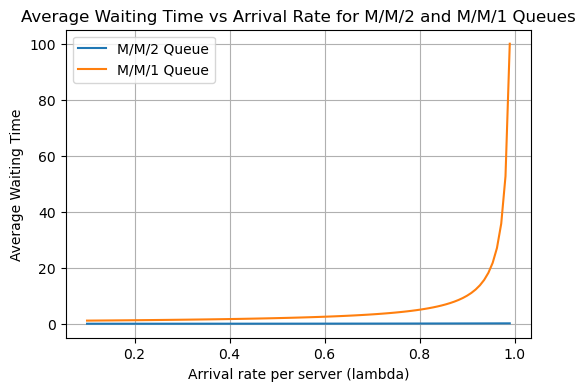

In [4]:
# Parameters
mu = 1
n = 2
lambda_rates = np.linspace(0.1, mu-0.01, 100)  # Vary lambda such that rho < 1 at all times

# Calculate waiting times for each value of lambda
waiting_times_mmn = [mxn_queue(lambda_rate, mu, n)[0] for lambda_rate in lambda_rates]
waiting_times_mm1 = [mx1_queue(lambda_rate, mu)[0] for lambda_rate in lambda_rates]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(lambda_rates, waiting_times_mmn, label='M/M/2 Queue')
plt.plot(lambda_rates, waiting_times_mm1, label='M/M/1 Queue')
plt.xlabel('Arrival rate per server (lambda)')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time vs Arrival Rate for M/M/2 and M/M/1 Queues')
plt.legend()
plt.grid(True)
plt.show()

### 2.
Using https://simpy.readthedocs.io/en/latest/examples/bank_renege.html tutorial code as base

In [5]:
def source(env, number, interval, counter, wait_times, dist_src='exp', dist_cst='exp', queue_time=QUEUE_TIME, service_time=INTERVAL_CUSTOMERS):
    """Source generates customers randomly"""
    for i in range(number):
        c = customer(env, f'Customer{i:02d}', counter, wait_times, dist=dist_cst, queue_time=queue_time, service_time=service_time)
        env.process(c)
        if dist_src == 'exp':
            t = random.expovariate(1.0 / interval)
        elif dist_src == 'const':
            t = interval
        else:
            raise ValueError('Invalid distribution')
        yield env.timeout(t)

def customer(env, name, counter, wait_times, dist='exp', queue_time=QUEUE_TIME, service_time=SERVICE_TIME):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    with counter.request() as req:
        results = yield req | env.timeout(queue_time)  # Timeout for waiting in the queue
        wait = env.now - arrive
        if req in results:
            if dist == 'exp':
                service_time = random.expovariate(1.0 / SERVICE_TIME) 
            elif dist == 'const':
                service_time = 12.0
            elif dist == 'hyperexp':
                r = random.random()
                if r < 0.25:
                    service_time = random.expovariate(1.0 / SERVICE_TIME)
                else:
                    service_time = random.expovariate(1.0 / (5 * SERVICE_TIME))
            else:
                raise ValueError('Invalid distribution')
            yield env.timeout(service_time)
            wait_times.append(wait)

def simulate_experiments(dist_src='exp', dist_cst='exp', ns=[1, 2, 4], n_sim=SIMULATIONS):
    """Run the simulations with provided parameters and return the waiting times and their averages"""
    wait_times_data = {n: [[] for _ in range(n_sim)] for n in ns}
    wait_times_data_mean = {n: [] for n in ns}
    for n in ns:
        for i in range(n_sim):
            random.seed(RANDOM_SEED+i)
            env = simpy.Environment()
            counter = simpy.Resource(env, capacity=n)
            wait_times = []
            env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter, wait_times, dist_src=dist_src, dist_cst=dist_cst))
            env.run()
            wait_times_data[n][i].append(wait_times)
            wait_times_data_mean[n] = np.mean(wait_times)
    return wait_times_data, wait_times_data_mean

def get_statistics(wait_times_data, print_results=True):
    """Calculate average, standard deviation, and 95% confidence interval for each simulation"""
    avgs, stds, conf_intervals = [], [], []
    for num_servers, times in wait_times_data.items():
        avg_wait_time = np.mean(times)
        avgs.append(avg_wait_time)
        std_dev = np.std(times)
        stds.append(std_dev)
        conf_interval = st.t.interval(0.95, len(times)-1, loc=avg_wait_time, scale=st.sem(times))
        conf_intervals.append(conf_interval)
        if print_results:
            c_low, c_high = conf_interval
            print(f'Servers: {num_servers}, mean waiting time: {avg_wait_time:.2f}, std dev: {std_dev:.2f}, 95% CI ({c_low:.2e} | {c_high:.2e})')
    return avgs, stds, conf_intervals

In [6]:
wait_times_data, wait_times_data_mean = simulate_experiments()
avgs, stds, conf_intervals = get_statistics(wait_times_data_mean)

for num_servers, times in wait_times_data.items():
    plt.plot(times, label=f'{num_servers} servers')

plt.xlabel('Simulation Run')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time per Simulation for Different Server Numbers')
plt.legend()
plt.show()

TypeError: object of type 'numpy.float64' has no len()

In [ ]:
def simulate_experiments(dist_src='exp', dist_cst='exp', ns=[1, 2, 4]):
    """Run the simulations with provided parameters and return the average waiting times"""
    wait_times_data = {n: [] for n in ns}
    for n in ns:
        for i in range(SIMULATIONS):
            random.seed(RANDOM_SEED+i) # Same seed for reproducibility
            env = simpy.Environment()
            counter = simpy.Resource(env, capacity=n)
            wait_times = []
            env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter, wait_times, dist_src=dist_src, dist_cst=dist_cst))
            env.run()
            wait_times_data[n].append(np.mean(wait_times))
    return wait_times_data

def get_statistics(wait_times_data, print_results=True):
    """Calculate average, standard deviation, and 95% confidence interval for each simulation"""
    avgs, stds, conf_intervals = [], [], []
    for num_servers, times in wait_times_data.items():
        avg_wait_time = np.mean(times)
        avgs.append(avg_wait_time)
        std_dev = np.std(times)
        stds.append(std_dev)
        conf_interval = st.t.interval(0.95, len(times)-1, loc=avg_wait_time, scale=st.sem(times))
        conf_intervals.append(conf_interval)
        if print_results:
            c_low, c_high = conf_interval
            print(f'Servers: {num_servers}, Average Waiting Time: {avg_wait_time:.2f}, Std Dev: {std_dev:.2f}, 95% CI: lower {c_low:.2e} | upper {c_high:.2e}')
    return avgs, stds, conf_intervals

def plot_wait_times_and_mean_ci(ns, wait_times_data, avgs, stds, conf_intervals, title):
    plt.figure(figsize=(9, 4), layout='tight')
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    for num_servers, times in wait_times_data.items():
        plt.hist(times, label=f'n={num_servers}', alpha=0.5)
    plt.xlabel('Average waiting time $\\tau$')
    plt.xscale('symlog', linthresh=0.1)
    plt.ylabel('Frequency $f$')
    plt.title('Frequency of average waiting times')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.errorbar(ns, avgs, yerr=stds, fmt='o', capsize=5, label='$\\mu \\pm 1\\sigma$')
    plt.xlabel('Number of servers $n$')
    plt.ylabel('Average waiting time $\\tau$')
    plt.title('Mean and standard deviation of waiting times')
    plt.legend(loc='upper right')
    plt.grid(True)
    # plt.savefig(f'{SAVE_DIR}/{title.replace(' ', '_').replace('/', '-')}.png')
    plt.show()

# Experiment
ns = np.arange(1, 6, 1, dtype=int)
wait_times_data = simulate_experiments(dist_src='exp', dist_cst='const', ns=ns)
avgs, stds, conf_intervals = get_statistics(wait_times_data)

plot_wait_times_and_mean_ci(ns, wait_times_data, avgs, stds, conf_intervals, title='$M/M/n$ queue simulations for different server numbers $n$')

In [ ]:
# Experiment
wait_times_data = simulate_experiments(dist_src='exp', dist_cst='hyperexp', ns=ns)
avgs, stds, conf_intervals = get_statistics(wait_times_data)

plot_wait_times_and_mean_ci(ns, wait_times_data, avgs, stds, conf_intervals, title='$M/H/n$ queue simulations for different server numbers $n$')

In [ ]:
ns = np.arange(1, 10, dtype=int)
# Calculate waiting times for each value of lambda
waiting_times_mxns_pserv = {n: [] for n in ns}
waiting_times_mxns = {n: [] for n in ns}
for n in ns:
    waiting_times_mxns_pserv[n] = [mxn_queue(lambda_rate*n, mu, n)[0] for lambda_rate in lambda_rates]
    waiting_times_mxns[n] = [mxn_queue(lambda_rate, mu, n)[0] for lambda_rate in lambda_rates]
waiting_times_mx1 = [mx1_queue(lambda_rate, mu)[0] for lambda_rate in lambda_rates]

# Plotting
plt.figure(figsize=(10, 4), dpi=300, layout='tight')
plt.suptitle('Average waiting time vs arrival rate for M/*/n queues', fontsize=14)
plt.subplot(1, 2, 1)
for n in ns:
    plt.plot(lambda_rates, waiting_times_mxns_pserv[n], label=f'M/*/{n}', alpha=0.7)
plt.xlabel('Arrival rate per server ($\\lambda\'$)')
plt.ylabel('Average waiting time $\\tau$')
plt.yscale('log')
plt.title('Arrival rate per server')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
for n in ns:
    plt.plot(lambda_rates, waiting_times_mxns[n], label=f'M/*/{n}', alpha=0.7)
plt.xlabel('Arrival rate ($\\lambda$)')
plt.ylabel('Average waiting time $\\tau$')
plt.yscale('log')
plt.title('Constant arrival rate')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
class SJFPriorityResource(simpy.PriorityResource):
    def _do_put(self, event):
        heapq.heappush(self.queue, (event.priority, next(self._put_counters), event)) # type: ignore

def customer(env, name, counter, service_time, wait_times, priority):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    if priority:
        with counter.request(priority=service_time) as req:  # Use service time as priority
            yield req
            wait = env.now - arrive
            yield env.timeout(service_time)
            wait_times.append(wait)
    else:
        with counter.request() as req:  # No priority
            yield req
            wait = env.now - arrive
            yield env.timeout(service_time)
            wait_times.append(wait)

def source(env, number, interval, counter, wait_times, priority):
    for i in range(number):
        service_time = random.expovariate(1.0 / SERVICE_TIME)
        c = customer(env, f'Customer{i:03d}', counter, service_time, wait_times, priority)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)

def run_simulation(num_servers, priority):
    random.seed(RANDOM_SEED)
    env = simpy.Environment()
    if priority:
        # Use SimPy's PriorityResource directly
        counter = simpy.PriorityResource(env, capacity=num_servers)
    else:
        counter = simpy.Resource(env, capacity=num_servers)
    wait_times = []
    env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter, wait_times, priority))
    env.run()
    return wait_times

# Run simulations for FIFO and SJF scheduling
print('Running FIFO simulation...')
wait_times_fifo = run_simulation(1, priority=False)
print(f'FIFO Average Wait Time: {np.mean(wait_times_fifo):.2f}, Std Dev: {np.std(wait_times_fifo):.2f}, 95% CI: {t.interval(0.95, len(wait_times_fifo)-1, loc=np.mean(wait_times_fifo), scale=sem(wait_times_fifo))}')

print('Running SJF simulation...')
wait_times_sjf = run_simulation(1, priority=True)
print(f'SJF Average Wait Time: {np.mean(wait_times_sjf):.2f}, Std Dev: {np.std(wait_times_sjf):.2f}, 95% CI: {t.interval(0.95, len(wait_times_sjf)-1, loc=np.mean(wait_times_sjf), scale=sem(wait_times_sjf))}')

In [ ]:
# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(wait_times_fifo, label='M/M/1 FIFO')
plt.plot(wait_times_sjf, label='M/M/1 SJF')
plt.xlabel('Customer')
plt.ylabel('Waiting Time')
plt.title('Comparison of Waiting Time per Customer for FIFO vs SJF Scheduling')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Histogram settings
bins = np.linspace(0, max(max(wait_times_fifo), max(wait_times_sjf)), 40)

plt.figure(figsize=(8, 4))

# FIFO Histogram
plt.hist(wait_times_fifo, bins, alpha=0.5, label='FIFO')

# SJF Histogram
plt.hist(wait_times_sjf, bins, alpha=0.5, label='SJF')

plt.xlabel('Waiting Time')
plt.ylabel('Frequency')
plt.title('Histogram of Waiting Times for FIFO vs SJF Scheduling')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
rs = []
for i in range(1000):
    rs.append(random.expovariate(1/(SERVICE_TIME*5))) 
print(np.mean(rs))
